In [32]:
from SciServer import CasJobs
from SciServer import LoginPortal
# Read the current access token from the file
my_access_token = LoginPortal.getToken()
query = "SELECT TOP 20 specobjid, ra, dec,z,class FROM specObjall where z  > 6.7 and zwarning = 0"
responseStream = CasJobs.executeQuery(query, "DR13", token = my_access_token)
result = responseStream.read()
print("\n---Query---\n{}\n---Result---\n{}".format(query, result))



---Query---
SELECT TOP 20 specobjid, ra, dec,z,class FROM specObjall where z  > 6.7 and zwarning = 0
---Result---
specobjid,ra,dec,z,class
8176470778201378816,70.283871,26.325275,6.720786,"QSO"
7464788232170770432,210.00153,39.980408,6.721344,"QSO"
826541960574560256,329.9596,12.788459,6.736117,"QSO"
8176552416939741184,71.475653,25.754972,6.741964,"QSO"
8176553516048715776,71.475653,25.754972,6.742186,"QSO"
1333209295155652608,124.9689,4.2546349,6.761738,"QSO"
8176467479263842304,70.141093,26.499698,6.768149,"QSO"
6169069023558242304,225.61083,18.010988,6.775421,"QSO"
7241833386636873728,177.01839,19.241384,6.776045,"QSO"
5364935691288317952,178.65251,3.0017707,6.785084,"QSO"
2106679728755730432,120.70079,55.224706,6.787088,"QSO"
8335181989645520896,174.89183,49.894571,6.795372,"QSO"
4455316318531227648,225.61083,18.010988,6.797021,"QSO"
5590243766550007808,239.14073,35.299264,6.800355,"QSO"
5699416201592967168,329.9596,12.788459,6.806602,"QSO"
5774796520793444352,23.701532,16.260026

RMS error = 0.25


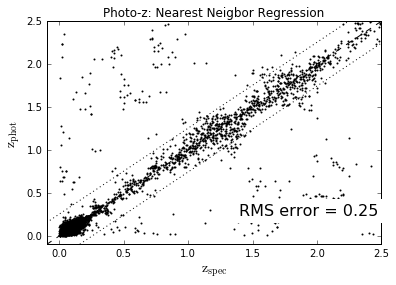

In [33]:
from io import StringIO
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from astroML.plotting import scatter_contour
from SciServer import CasJobs
from SciServer import LoginPortal
NOBJECTS = 20000
GAL_COLORS_DTYPE = [('u', float),
                    ('g', float),
                    ('r', float),
                    ('i', float),
                    ('z', float),
                    ('redshift', float),
                    ('redshift_err', float)]
# get access token
my_access_token = LoginPortal.getToken()
# get data from CasJobs
query_text = ('\n'.join(
    ("SELECT TOP %i" % NOBJECTS,
    "   p.u, p.g, p.r, p.i, p.z, s.z, s.zerr",
    "FROM PhotoObj AS p",
    "   JOIN SpecObj AS s ON s.bestobjid = p.objid",
    "WHERE ",
    "   p.u BETWEEN 0 AND 19.6",
    "   AND p.g BETWEEN 0 AND 20",
    "   AND (s.class = 'GALAXY' OR s.class = 'QSO') AND s.zwarning=0")))
response = CasJobs.executeQuery(query_text, "DR12", token = my_access_token)
output = StringIO(response.read())
data = np.loadtxt(output, delimiter=',',skiprows=1, dtype=GAL_COLORS_DTYPE)
n_neighbors = 1
N = len(data)
# shuffle data
np.random.seed(0)
np.random.shuffle(data)
# put colors in a matrix
X = np.zeros((N, 4))
X[:, 0] = data['u'] - data['g']
X[:, 1] = data['g'] - data['r']
X[:, 2] = data['r'] - data['i']
X[:, 3] = data['i'] - data['z']
z = data['redshift']
# divide into training and testing data
Ntrain = N / 2
Xtrain = X[:Ntrain]
ztrain = z[:Ntrain]
Xtest = X[Ntrain:]
ztest = z[Ntrain:]
knn = KNeighborsRegressor(n_neighbors, weights='uniform')
zpred = knn.fit(Xtrain, ztrain).predict(Xtest)
rms = np.sqrt(np.mean((ztest - zpred) ** 2))
print("RMS error = %.2g" % rms)
axis_lim = np.array([-0.1, 2.5])
ax = plt.axes()
plt.scatter(ztest, zpred, c='k', lw=0, s=4)
plt.plot(axis_lim, axis_lim, '--k')
plt.plot(axis_lim, axis_lim + rms, ':k')
plt.plot(axis_lim, axis_lim - rms, ':k')
plt.xlim(axis_lim)
plt.ylim(axis_lim)
plt.text(0.99, 0.12, "RMS error = %.2g" % rms,
         ha='right', va='bottom', transform=ax.transAxes,
         bbox=dict(ec='w', fc='w'), fontsize=16)
plt.title('Photo-z: Nearest Neigbor Regression')
plt.xlabel(r'$\mathrm{z_{spec}}$', fontsize=14)
plt.ylabel(r'$\mathrm{z_{phot}}$', fontsize=14)
plt.show()


In [18]:
plt.savefig('test.png')